# Executice Summary

Project 2 for Metis

Education data

# Setup

In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import unicodedata
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data

Scraping Data from Websites

Various data sets all scrapped, no API used

## State ranking data

In [2]:
import requests

url = 'https://wallethub.com/edu/states-with-the-best-schools/5335/'

response = requests.get(url)

In [3]:
page = response.text

In [4]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(page,"lxml")

In [5]:
rank_dict = {}

for i in range(51):
    rank = soup.find(class_='cardhub-edu-table center-aligned sortable').find_all('td')[5*i].text
    state = soup.find(class_='cardhub-edu-table center-aligned sortable').find_all('td')[1+5*i].text
    state = state.replace(' ','')
    score = soup.find(class_='cardhub-edu-table center-aligned sortable').find_all('td')[2+5*i].text
    quality = soup.find(class_='cardhub-edu-table center-aligned sortable').find_all('td')[3+5*i].text
    safety = soup.find(class_='cardhub-edu-table center-aligned sortable').find_all('td')[4+5*i].text
    rank_dict[rank] = [state,float(score),int(quality),int(safety)]

In [6]:
df_rank = pd.DataFrame.from_dict(rank_dict, orient='index', dtype=None)
df_rank.rename(index=str, columns={0: 'State', 1: 'Overall_score',2:'Quality_rank', 
                                   3:'Safety_rank'}, inplace = True)

##### State Rank data frame

In [7]:
df_rank.sample(5)

,State,Overall_score,Quality_rank,Safety_rank
38,Georgia,47.32,36,38
18,Oklahoma,55.22,37,3
5,Vermont,64.09,5,11
27,Kentucky,51.58,13,41
7,Minnesota,62.68,7,18


## State budget data

In [8]:
url = 'https://en.wikipedia.org/wiki/List_of_U.S._state_budgets'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [9]:
budget_dict = {}

for i in range(50):
    state = soup.find(class_='mw-parser-output').find_all('td')[6*i].text
    state = state.replace(' ','')
    
    budget = soup.find(class_='mw-parser-output').find_all('td')[1+6*i].text
    budget = float(budget)
    
    fy = soup.find(class_='mw-parser-output').find_all('td')[2+6*i].text
    loc = fy.find('–')
    if fy.find('–') != -1:
        front = int(fy[:loc])
        back = int('20' + fy[loc+1:])
        years = back - front + 1
    else: 
        back = int(fy)
        years = 1
    
    budget_per_capita = soup.find(class_='mw-parser-output').find_all('td')[4+6*i].text
    budget_per_capita = int(budget_per_capita.replace(',',''))
    
    credit_rating = soup.find(class_='mw-parser-output').find_all('td')[5+6*i].text
    
    budget_dict[state] = [budget,back,years,budget_per_capita,credit_rating]

In [10]:
df_budget = pd.DataFrame.from_dict(budget_dict, orient='index', dtype=None)
df_budget.rename(index=str, columns={0: 'Budget_billion', 1: 'Year_end',2:'No_years', 3:'Per_capita',
                                     4:'Credit_rating'}, inplace = True)

In [11]:
df_budget = df_budget.reset_index(level=0)
df_budget.rename(columns = {'index' : 'State'}, inplace = True)

##### State Budget data drame

In [12]:
df_budget.sample(5)

,State,Budget_billion,Year_end,No_years,Per_capita,Credit_rating
25,Montana,10.1,2017,2,9778,AA
27,Nevada,23.8,2017,3,8233,AA
40,SouthDakota,4.5,2017,1,5242,AAA
39,SouthCarolina,26.3,2017,2,5372,AA+
48,Wisconsin,36.9,2017,2,6394,AA


## Teacher salary

In [13]:
from urllib.request import Request, urlopen

site= "https://articles.niche.com/teacher-salaries-in-america/"
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(site,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page,'lxml')

In [14]:
salary_dict = {}

for i in range(50):
    state = soup.find(class_='table-wrap ').find_all('td')[3*i].text
    state = state.replace('\n','').replace('State','').replace(' ','')
    
    start_salary = soup.find(class_='table-wrap ').find_all('td')[3*i + 1].text
    start_salary = int(start_salary.replace('\n','').replace('Average Starting Salary','')
                       .replace(',','').replace('$',''))
    
    salary = soup.find(class_='table-wrap ').find_all('td')[3*i + 2].text
    salary = int(salary.replace('\n','').replace('Average Salary','').replace(',','').replace('$',''))
    
    salary_dict[state] = [start_salary, salary]

In [15]:
df_salary = pd.DataFrame.from_dict(salary_dict, orient='index', dtype=None)
df_salary.rename(index=str, columns={0: 'Starting_salary', 1: 'Salary'}, inplace = True)

In [16]:
df_salary = df_salary.reset_index(level=0)
df_salary.rename(columns = {'index' : 'State'}, inplace = True)

##### Teacher Salary data frame

In [17]:
df_salary.sample(5)

,State,Starting_salary,Salary
19,Maine,33876,51077
39,RhodeIsland,41481,66477
31,NewMexico,34544,47500
43,Texas,40725,52575
47,Washington,40426,54147


## Medium Income

In [18]:
url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_by_income'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [19]:
income_dict = {}

for i in range(54):
    rank = soup.find(class_='mw-parser-output').find_all('td')[6+7*i].text
    if rank:
        state = soup.find(class_='mw-parser-output').find_all('td')[7+7*i].text
        state = state.replace(' ','')
        income = soup.find(class_='mw-parser-output').find_all('td')[8+7*i].text
        income = int(income.replace(',','').replace('$',''))
        income_dict[rank] = [state, income]
    

In [20]:
df_income = pd.DataFrame.from_dict(income_dict, orient='index', dtype=None)
df_income.rename(index=str, columns={0: 'State', 1: 'Income'}, inplace = True)

##### Income data frame

In [21]:
df_income.sample(5)

,State,Income
12,Minnesota,63488
30,Maine,51494
11,Colorado,63909
46,Kentucky,45215
36,Missouri,50238


## Class Size

In [22]:
url = 'https://nces.ed.gov/surveys/sass/tables/sass1112_2013314_t1s_007.asp'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [23]:
class_size_dict = {}

for i in range(60):
    warning = ''
    state = soup.find('tbody').find_all('th')[2+i].text
    state = state.replace('\r','').replace('\n','').replace(' ','')
    state = state.strip()
    if state: # ignores blank cells
        
        # Primary School
        PS_selfcont = soup.find('tbody').find_all('td')[32+16*i].text
        if PS_selfcont == '‡': PS_selfcont = '0'
        warning = soup.find('tbody').find_all('td')[33+16*i].text
        if warning == '!': PS_selfcont = '0'
        PS_selfcont = float(PS_selfcont)
        
        PS_dep = soup.find('tbody').find_all('td')[34+16*i].text
        if PS_dep == '‡': PS_dep = '0'
        warning = soup.find('tbody').find_all('td')[35+16*i].text
        if warning =='!': PS_dep = '0'
        PS_dep = float(PS_dep)
        
        # Middle School
        MS_selfcont = soup.find('tbody').find_all('td')[36+16*i].text
        if MS_selfcont == '‡': MS_selfcont = '0'
        warning = soup.find('tbody').find_all('td')[37+16*i].text
        if warning == '!': MS_selfcont = '0'
        MS_selfcont = float(MS_selfcont)
        
        MS_dep = soup.find('tbody').find_all('td')[38+16*i].text
        if MS_dep == '‡': MS_dep = '0'
        warning = soup.find('tbody').find_all('td')[39+16*i].text
        if warning == '!': MS_dep = '0'
        MS_dep = float(MS_dep)
        
        # High School
        HS_selfcont = soup.find('tbody').find_all('td')[40+16*i].text
        if HS_selfcont == '‡': HS_selfcont = '0'
        warning = soup.find('tbody').find_all('td')[41+16*i].text
        if warning == '!': HS_selfcont = '0'
        HS_selfcont = float(HS_selfcont)
        
        HS_dep = soup.find('tbody').find_all('td')[42+16*i].text
        if HS_dep == '‡': HS_dep = '0'
        warning = soup.find('tbody').find_all('td')[43+16*i].text
        if warning == '!': HS_dep = '0'
        HS_dep = float(HS_dep)
        
        # Combined Grades
        CG_selfcont = soup.find('tbody').find_all('td')[44+16*i].text
        if CG_selfcont == '‡': CG_selfcont = '0'
        warning = soup.find('tbody').find_all('td')[45+16*i].text
        if warning == '!': CG_selfcont = '0'
        CG_selfcont = float(CG_selfcont)
        
        CG_dep = soup.find('tbody').find_all('td')[46+16*i].text
        if CG_dep == '‡': CG_dep = '0'
        warning = soup.find('tbody').find_all('td')[47+16*i].text
        if warning == '!': CG_dep = '0'
        CG_dep = float(CG_dep)

        class_size_dict[state] = [PS_selfcont, PS_dep, MS_selfcont, MS_dep, HS_selfcont, HS_dep, 
                                  CG_selfcont, CG_dep]

In [24]:
df_class_size = pd.DataFrame.from_dict(class_size_dict, orient='index', dtype=None)
df_class_size.rename(index=str, columns={0: 'Primary_SCC', 1: 'Primary_DI',2:'Middle_SCC',
                                         3:'Middle_DI',4:'High_SCC',5:'High_DI',6:'Combine_SCC',
                                         7:'Combine_DI'}, inplace = True)
df_class_size = df_class_size.reset_index(level=0)
df_class_size.rename(columns = {'index' : 'State'}, inplace = True)

##### Class Size Data Frame

In [25]:
df_class_size.sample(5)

,State,Primary_SCC,Primary_DI,Middle_SCC,Middle_DI,High_SCC,High_DI,Combine_SCC,Combine_DI
44,Utah,27.6,8.3,19.6,29.4,25.4,29.0,21.9,0.0
47,Washington,23.9,37.0,29.1,27.0,28.5,27.0,17.7,15.4
11,Hawaii,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,Iowa,20.9,21.5,15.6,27.8,12.2,22.8,16.0,21.0
23,Minnesota,23.7,31.0,0.0,29.5,21.9,27.0,16.8,23.1


## Education budget, itemized

In [4]:
money = {
      "State": [
        "Utah",
        "Idaho",
        "Arizona",
        "Oklahoma",
        "Mississippi",
        "Nevada",
        "North Carolina",
        "Texas",
        "Tennessee",
        "Florida",
        "South Dakota",
        "Colorado",
        "Alabama",
        "Georgia",
        "Kentucky",
        "Indiana",
        "California",
        "Arkansas",
        "South Carolina",
        "New Mexico",
        "Missouri",
        "Oregon",
        "Kansas",
        "Washington",
        "Iowa",
        "Louisiana",
        "Virginia",
        "U.S. Total",
        "Montana",
        "Michigan",
        "Wisconsin",
        "West Virginia",
        "Ohio",
        "Minnesota",
        "Nebraska",
        "North Dakota",
        "Hawaii",
        "Maine",
        "Illinois",
        "Delaware",
        "Pennsylvania",
        "Maryland",
        "New Hampshire",
        "Rhode Island",
        "Massachusetts",
        "Wyoming",
        "Vermont",
        "Connecticut",
        "New Jersey",
        "Alaska",
        "District of Columbia",
        "New York"],
      "Instruction_Employee_Salaries": [
        "2,562",
        "2,741",
        "2,855",
        "2,883",
        "3,098",
        "3,180",
        "3,609",
        "3,934",
        "3,555",
        "3,214",
        "3,592",
        "3,620",
        "3,359",
        "3,785",
        "3,747",
        "3,516",
        "3,779",
        "3,631",
        "3,737",
        "3,595",
        "4,096",
        "3,350",
        "3,833",
        "3,958",
        "4,508",
        "3,789",
        "4,580",
        "4,378",
        "4,243",
        "3,857",
        "4,310",
        "3,862",
        "4,435",
        "5,085",
        "4,938",
        "5,073",
        "4,711",
        "5,050",
        "4,747",
        "5,374",
        "5,368",
        "5,544",
        "5,673",
        "5,961",
        "6,343",
        "6,094",
        "6,564",
        "6,997",
        "6,888",
        "5,260",
        "8,704",
        "8,712"],
      "Instruction_Employee_Benefits": [
        "1,193",
        "957",
        "889",
        "977",
        "1,049",
        "1,272",
        "1,221",
        "626",
        "1,188",
        "954",
        "1,050",
        "983",
        "1,234",
        "1,389",
        "1,329",
        "1,808",
        "1,288",
        "1,058",
        "1,279",
        "1,249",
        "1,218",
        "1,912",
        "1,202",
        "1,386",
        "1,502",
        "1,832",
        "1,690",
        "1,691",
        "1,321",
        "2,196",
        "1,877",
        "1,991",
        "1,617",
        "1,689",
        "1,705",
        "1,721",
        "1,738",
        "2,168",
        "2,504",
        "2,734",
        "2,623",
        "2,561",
        "2,563",
        "2,551",
        "2,447",
        "2,495",
        "2,756",
        "3,409",
        "2,782",
        "4,127",
        "1,452",
        "4,660"],
      "Pupil_Support": [
        "233",
        "366",
        "578",
        "548",
        "404",
        "452",
        "452",
        "429",
        "382",
        "383",
        "479",
        "435",
        "526",
        "427",
        "436",
        "459",
        "511",
        "500",
        "766",
        "734",
        "458",
        "702",
        "497",
        "697",
        "609",
        "658",
        "548",
        "619",
        "704",
        "885",
        "546",
        "558",
        "767",
        "317",
        "488",
        "497",
        "1,120",
        "886",
        "877",
        "651",
        "773",
        "647",
        "1,102",
        "1,665",
        "1,161",
        "933",
        "1,423",
        "1,149",
        "1,919",
        "1,488",
        "970",
        "636"],
      "Instructional_Staff_Support": [
        "261",
        "309",
        "433",
        "330",
        "397",
        "488",
        "284",
        "436",
        "544",
        "544",
        "335",
        "524",
        "387",
        "465",
        "516",
        "355",
        "541",
        "806",
        "583",
        "253",
        "450",
        "361",
        "393",
        "638",
        "523",
        "574",
        "710",
        "509",
        "417",
        "535",
        "565",
        "458",
        "493",
        "546",
        "369",
        "414",
        "420",
        "634",
        "508",
        "263",
        "478",
        "754",
        "447",
        "611",
        "877",
        "904",
        "772",
        "530",
        "576",
        "1,259",
        "1,098",
        "509"],
      "General_Administration": [
        "63",
        "142",
        "101",
        "252",
        "265",
        "102",
        "97",
        "129",
        "190",
        "78",
        "298",
        "139",
        "235",
        "115",
        "222",
        "185",
        "95",
        "223",
        "98",
        "186",
        "332",
        "136",
        "246",
        "116",
        "276",
        "274",
        "179",
        "210",
        "342",
        "183",
        "305",
        "223",
        "324",
        "388",
        "335",
        "536",
        "53",
        "453",
        "518",
        "183",
        "393",
        "125",
        "495",
        "182",
        "204",
        "309",
        "386",
        "389",
        "367",
        "256",
        "1,767",
        "341"],
      "School_Administration": [
        "400",
        "381",
        "348",
        "447",
        "495",
        "601",
        "545",
        "485",
        "511",
        "481",
        "435",
        "629",
        "560",
        "562",
        "540",
        "561",
        "627",
        "497",
        "603",
        "1,274",
        "574",
        "642",
        "582",
        "608",
        "608",
        "629",
        "651",
        "607",
        "601",
        "599",
        "563",
        "606",
        "601",
        "453",
        "557",
        "620",
        "806",
        "720",
        "648",
        "881",
        "577",
        "981",
        "821",
        "719",
        "670",
        "861",
        "1,191",
        "1,057",
        "904",
        "1,158",
        "1,636",
        "767"],
      "Other": [
        "1,788",
        "1,726",
        "2,323",
        "2,391",
        "2,554",
        "2,319",
        "2,304",
        "2,553",
        "2,259",
        "3,102",
        "2,693",
        "2,655",
        "2,727",
        "2,458",
        "2,522",
        "2,664",
        "2,754",
        "2,899",
        "2,666",
        "2,443",
        "2,748",
        "2,841",
        "3,219",
        "2,799",
        "2,643",
        "2,993",
        "2,614",
        "2,995",
        "3,390",
        "2,855",
        "3,021",
        "3,562",
        "3,117",
        "2,985",
        "3,334",
        "3,496",
        "3,609",
        "2,795",
        "3,275",
        "3,851",
        "3,749",
        "3,392",
        "3,233",
        "3,078",
        "3,384",
        "4,203",
        "3,896",
        "4,214",
        "4,470",
        "4,866",
        "2,859",
        "4,985"]
}

In [6]:
import pandas as pd
df_money = pd.DataFrame.from_dict(money, orient='columns')

In [7]:
df_money['Budget'] = [3] * len(df_money['General_Administration'])

for i in range(len(df_money['General_Administration'])):
    a = df_money['State'][i].replace(' ','')
    df_money.iloc[i,df_money.columns.get_loc('State')] = a
    a = str(df_money['General_Administration'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('General_Administration')] = int(a)
    a = str(df_money['Instruction_Employee_Benefits'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('Instruction_Employee_Benefits')] = int(a)
    a = str(df_money['Instruction_Employee_Salaries'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('Instruction_Employee_Salaries')] = int(a)
    a = str(df_money['Instructional_Staff_Support'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('Instructional_Staff_Support')] = int(a)
    a = str(df_money['Pupil_Support'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('Pupil_Support')] = int(a)
    a = str(df_money['Other'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('Other')] = int(a)
    a = str(df_money['School_Administration'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('School_Administration')] = int(a)
    
    
    b = (df_money['General_Administration'][i]+df_money['Instruction_Employee_Benefits'][i]+
        df_money['Instruction_Employee_Salaries'][i]+df_money['Instructional_Staff_Support'][i]+
        df_money['Pupil_Support'][i]+df_money['Other'][i]+
        df_money['School_Administration'][i])
    
    df_money.iloc[i,df_money.columns.get_loc('Budget')] = int(b)
    

##### Education budget data frame

In [10]:
df_money.sort_values(by='Budget')

,General_Administration,Instruction_Employee_Benefits,Instruction_Employee_Salaries,Instructional_Staff_Support,Other,Pupil_Support,School_Administration,State,Budget
0,63,1193,2562,261,1788,233,400,Utah,6500
1,142,957,2741,309,1726,366,381,Idaho,6622
2,101,889,2855,433,2323,578,348,Arizona,7527
3,252,977,2883,330,2391,548,447,Oklahoma,7828
4,265,1049,3098,397,2554,404,495,Mississippi,8262
5,102,1272,3180,488,2319,452,601,Nevada,8414
6,97,1221,3609,284,2304,452,545,NorthCarolina,8512
7,129,626,3934,436,2553,429,485,Texas,8592
8,190,1188,3555,544,2259,382,511,Tennessee,8629
9,78,954,3214,544,3102,383,481,Florida,8756


## Days of instuction data

http://www.ecs.org/clearinghouse/95/05/9505.pdf
Pdf so manual entry was used. Also took some deciphering

In [30]:
days_instruction_dict = {
'Alabama':180,
'Alaska':170,
'Arizona':180,
'Arkansas':178,
'California':180,
'Colorado':160,
'Connecticut':180,
'Delaware':181,
'DistrictofColumbia':178,
'Florida':180,
'Georgia':180,
'Hawaii':180,
'Idaho':173,
'Illinois':176,
'Indiana':180,
'Iowa':180,
'Kansas':186,
'Kentucky':175,
'Louisiana':178,
'Maine':175,
'Maryland':180,
'Massachusetts':180,
'Michigan':170,
'Minnesota':165,
'Mississippi':180,
'Missouri':142,
'Montana':174,
'Nebraska':176,
'Nevada':180,
'NewHampshire':180,
'NewJersey':180,
'NewMexico':180,
'NewYork':180,
'NorthCarolina':180,
'NorthDakota':175,
'Ohio':182,
'Oklahoma':180,
'Oregon':175,
'Pennsylvania':180,
'RhodeIsland':180,
'SouthCarolina':180,
'SouthDakota':180,
'Tennessee':180,
'Texas':180,
'Utah':180,
'Vermont':175,
'Virginia':180,
'Washington':180,
'WestVirginia':180,
'Wisconsin':180,
'Wyoming':180}

In [31]:
df_instruction = pd.DataFrame.from_dict(days_instruction_dict, orient='index')
df_instruction.rename(index=str, columns={0: 'Days_of_instruction'}, inplace = True)
df_instruction = df_instruction.reset_index(level=0)
df_instruction.rename(columns = {'index' : 'State'}, inplace = True)

##### Days of instruction data frame

In [32]:
df_instruction.sample(5)

,State,Days_of_instruction
46,Virginia,180
50,Wyoming,180
36,Oklahoma,180
17,Kentucky,175
41,SouthDakota,180


## Incarceration data

In [33]:
url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_by_incarceration_and_correctional_supervision_rate'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [34]:
incarceration_dict = {}

for i in range(51):
    state = soup.find(class_='mw-parser-output').find_all('td')[53+4*i].text
    state = state.replace(' ','')
    number = soup.find(class_='mw-parser-output').find_all('td')[55+4*i].text
    number = int(number.replace(',',''))
    incarceration_dict[state] = [number]

In [35]:
df_incarceration = pd.DataFrame.from_dict(incarceration_dict, orient='index')
df_incarceration.rename(index=str, columns={0: 'Number_of_incarceration'}, inplace = True)
df_incarceration = df_incarceration.reset_index(level=0)
df_incarceration.rename(columns = {'index' : 'State'}, inplace = True)

##### Number of incarcerated per 100,000

In [36]:
df_incarceration.sample(5)

,State,Number_of_incarceration
0,Alabama,1230
45,Vermont,410
26,Montana,760
17,Kentucky,950
27,Nebraska,600


## Mental illness rate

In [37]:
url = 'http://oas.samhsa.gov/2k11/078/WEB_SR_078.htm'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [38]:
mental_dict = {}

a = "A table comparing serious mental illness (SMI) in past year among persons aged 18 or older, by location: percentages, annual averages based on 2008 and 2009 NSDUHs."
b = "A table comparing any mental illness in past year among persons aged 18 or older, by location: percentages, annual averages based on 2008 and 2009 NSDUHs."
for i in range(51):
    state = soup.find(summary=a).find_all('td')[3+3*i].text
    state = state.replace(' ','')
    number_SMI = soup.find(summary=a).find_all('td')[4+3*i].text
    number_SMI = float(number_SMI.replace('%',''))
    number_AMI = soup.find(summary=b).find_all('td')[4+3*i].text
    number_AMI = float(number_AMI.replace('%',''))
    mental_dict[state] = [number_SMI, number_AMI]

In [39]:
df_mental_health = pd.DataFrame.from_dict(mental_dict, orient='index')
df_mental_health.rename(index=str, columns={0: 'Percent_SMI', 1: 'Percent_AMI'}, inplace = True)
df_mental_health = df_mental_health.reset_index(level=0)
df_mental_health.rename(columns = {'index' : 'State'}, inplace = True)

##### Mental illness rate data frame

In [40]:
df_mental_health.sample(5)

,State,Percent_SMI,Percent_AMI
16,Kansas,4.4,20.6
40,SouthCarolina,4.1,18.9
48,WestVirginia,6.1,22.0
38,Pennsylvania,3.8,17.7
20,Maryland,3.6,16.7


## Married parent data

https://www.nytimes.com/2015/06/13/upshot/red-vs-blue-america-on-marriage.html?rref=upshot&smid=tw-upshotnyt

In [41]:
married_dict = {
'Alabama':38,
'Alaska':45,
'Arizona':41,
'Arkansas':37,
'California':47,
'Colorado':48,
'Connecticut':51,
'Delaware':42,
'DistrictofColumbia':46,
'Florida':41,
'Georgia':39,
'Hawaii':50,
'Idaho':51,
'Illinois':49,
'Indiana':44,
'Iowa':51,
'Kansas':49,
'Kentucky':42,
'Louisiana':36,
'Maine':45,
'Maryland':46,
'Massachusetts':52,
'Michigan':46,
'Minnesota':56,
'Mississippi':32,
'Missouri':43,
'Montana':48,
'Nebraska':55,
'Nevada':39,
'NewHampshire':53,
'NewJersey':54,
'NewMexico':39,
'NewYork':48,
'NorthCarolina':42,
'NorthDakota':49,
'Ohio':45,
'Oklahoma':39,
'Oregon':46,
'Pennsylvania':49,
'RhodeIsland':44,
'SouthCarolina':39,
'SouthDakota':49,
'Tennessee':40,
'Texas':45,
'Utah':57,
'Vermont':49,
'Virginia':48,
'Washington':48,
'WestVirginia':41,
'Wisconsin':50,
'Wyoming':46}

In [42]:
df_married = pd.DataFrame.from_dict(married_dict, orient='index')
df_married.rename(index=str, columns={0: 'Percent_married'}, inplace = True)
df_married = df_married.reset_index(level=0)
df_married.rename(columns = {'index' : 'State'}, inplace = True)

##### Married percent data frame

In [43]:
df_married.sample(5)

,State,Percent_married
31,NewMexico,39
22,Michigan,46
41,SouthDakota,49
16,Kansas,49
33,NorthCarolina,42


## Poverty rate

In [44]:
url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_poverty_rate'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [45]:
poverty_dict = {}

for i in range(51):
    state = soup.find(class_='mw-content-ltr').find_all('td')[13+6*i].text
    state = state.replace(' ','').replace('\xa0','')
    poverty = soup.find(class_='mw-content-ltr').find_all('td')[14+6*i].text
    poverty = float(poverty.replace('%',''))
    poverty_dict[state] = [poverty]    

In [46]:
df_poverty = pd.DataFrame.from_dict(poverty_dict, orient='index')
df_poverty.rename(index=str, columns={0: 'Percent_poverty'}, inplace = True)
df_poverty = df_poverty.reset_index(level=0)
df_poverty.rename(columns = {'index' : 'State'}, inplace = True)

##### Percent poverty data frame

In [47]:
df_poverty.sample(5)

,State,Percent_poverty
9,Massachusetts,11.7
27,Indiana,15.2
17,Wisconsin,13.2
3,Connecticut,10.8
10,Virginia,11.8


## Health care ranking

In [48]:
url = 'https://wallethub.com/edu/states-with-best-health-care/23457/'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [49]:
healthcare_dict = {}

for i in range(51):
    state = soup.find(class_="container content").find_all('td')[1+6*i].text
    state = state.replace(' ','')
    Overall_score_H = soup.find(class_="container content").find_all('td')[2+6*i].text
    Overall_score_H = float(Overall_score_H)
    Cost_H = soup.find(class_="container content").find_all('td')[3+6*i].text
    Cost_H = int(Cost_H)
    Access_H = soup.find(class_="container content").find_all('td')[4+6*i].text
    Access_H = int(Access_H)
    Outcome_H = soup.find(class_="container content").find_all('td')[5+6*i].text
    Outcome_H = int(Outcome_H)
    healthcare_dict[state] = [Overall_score_H,Cost_H,Access_H,Outcome_H]

In [50]:
df_healthcare = pd.DataFrame.from_dict(healthcare_dict, orient='index')
df_healthcare.rename(index=str, columns={0: 'Overall_score_H', 1:'Cost_h_rank', 2:'Access_h_rank',
                                        3:'Outcome_h_rank'}, inplace = True)
df_healthcare = df_healthcare.reset_index(level=0)
df_healthcare.rename(columns = {'index' : 'State'}, inplace = True)

##### Healthcare data frame

In [51]:
df_healthcare.sample(5)

,State,Overall_score_H,Cost_h_rank,Access_h_rank,Outcome_h_rank
33,Oregon,52.88,37,45,15
46,NorthCarolina,44.45,50,44,36
22,Delaware,56.55,8,25,40
12,Colorado,62.62,23,20,4
23,NewJersey,56.43,29,39,12


# Manipulation

In [52]:
result = pd.merge(df_rank,df_salary,on='State')
result.head()

,State,Overall_score,Quality_rank,Safety_rank,Starting_salary,Salary
0,Massachusetts,78.16,1,1,44726,77804
1,NewJersey,66.92,2,15,51179,69623
2,NewHampshire,64.65,4,14,36845,57253
3,Wisconsin,64.25,6,7,36983,54998
4,Vermont,64.09,5,11,38483,60187


In [53]:
result = pd.merge(result,df_income,on='State')
result = pd.merge(result,df_money,on='State')
result = pd.merge(result,df_instruction,on='State')
result = pd.merge(result,df_incarceration,on='State')
result = pd.merge(result,df_mental_health,on='State')
result = pd.merge(result,df_poverty,on='State')
result = pd.merge(result,df_healthcare,on='State')
result = pd.merge(result,df_married,on='State')

In [54]:
result1 = result.drop(['General_Administration','Instruction_Employee_Benefits',
                          'Instruction_Employee_Salaries','Instructional_Staff_Support',
                          'Other','Pupil_Support','School_Administration','Days_of_instruction',
                          'Percent_AMI', 'Cost_h_rank','Access_h_rank','Outcome_h_rank','Starting_salary'],1)

In [55]:
result1.corr()

,Overall_score,Quality_rank,Safety_rank,Salary,Income,Budget,Number_of_incarceration,Percent_SMI,Percent_poverty,Overall_score_H,Percent_married
Overall_score,1.000000,-0.870543,-0.798956,0.397292,0.559595,0.379418,-0.627074,-0.131972,-0.718104,0.672950,0.704728
Quality_rank,-0.870543,1.000000,0.488974,-0.361223,-0.498897,-0.465702,0.616553,-0.027035,0.676407,-0.642890,-0.662595
Safety_rank,-0.798956,0.488974,1.000000,-0.202369,-0.405059,-0.138569,0.442733,0.209957,0.539715,-0.504480,-0.484275
Salary,0.397292,-0.361223,-0.202369,1.000000,0.648897,0.758127,-0.454299,-0.177429,-0.412568,0.310051,0.397297
Income,0.559595,-0.498897,-0.405059,0.648897,1.000000,0.602636,-0.551058,-0.365149,-0.851151,0.594387,0.691589
Budget,0.379418,-0.465702,-0.138569,0.758127,0.602636,1.000000,-0.517864,-0.214484,-0.510921,0.336213,0.364298
Number_of_incarceration,-0.627074,0.616553,0.442733,-0.454299,-0.551058,-0.517864,1.000000,-0.058711,0.692920,-0.771355,-0.746797
Percent_SMI,-0.131972,-0.027035,0.209957,-0.177429,-0.365149,-0.214484,-0.058711,1.000000,0.199595,-0.084646,-0.062378
Percent_poverty,-0.718104,0.676407,0.539715,-0.412568,-0.851151,-0.510921,0.692920,0.199595,1.000000,-0.751678,-0.834091
Overall_score_H,0.672950,-0.642890,-0.504480,0.310051,0.594387,0.336213,-0.771355,-0.084646,-0.751678,1.000000,0.792286


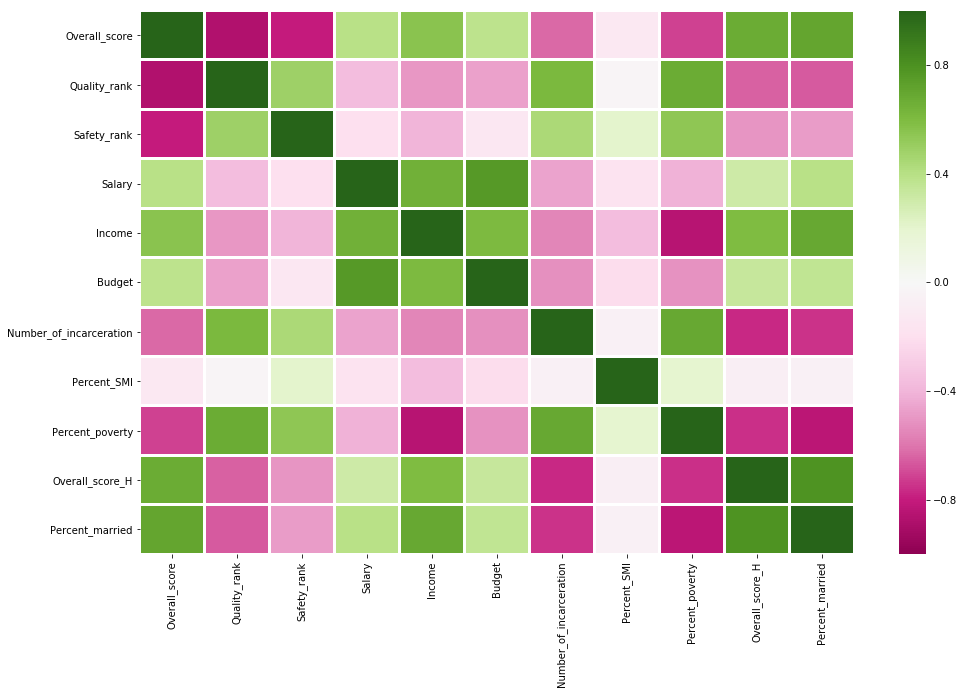

In [56]:
plt.figure(figsize = (16,10))

ax = sns.heatmap(result1.corr(),vmin=-1,vmax=1,linewidths=2,fmt="d",cmap="PiYG")

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

# Verify our versions
import matplotlib

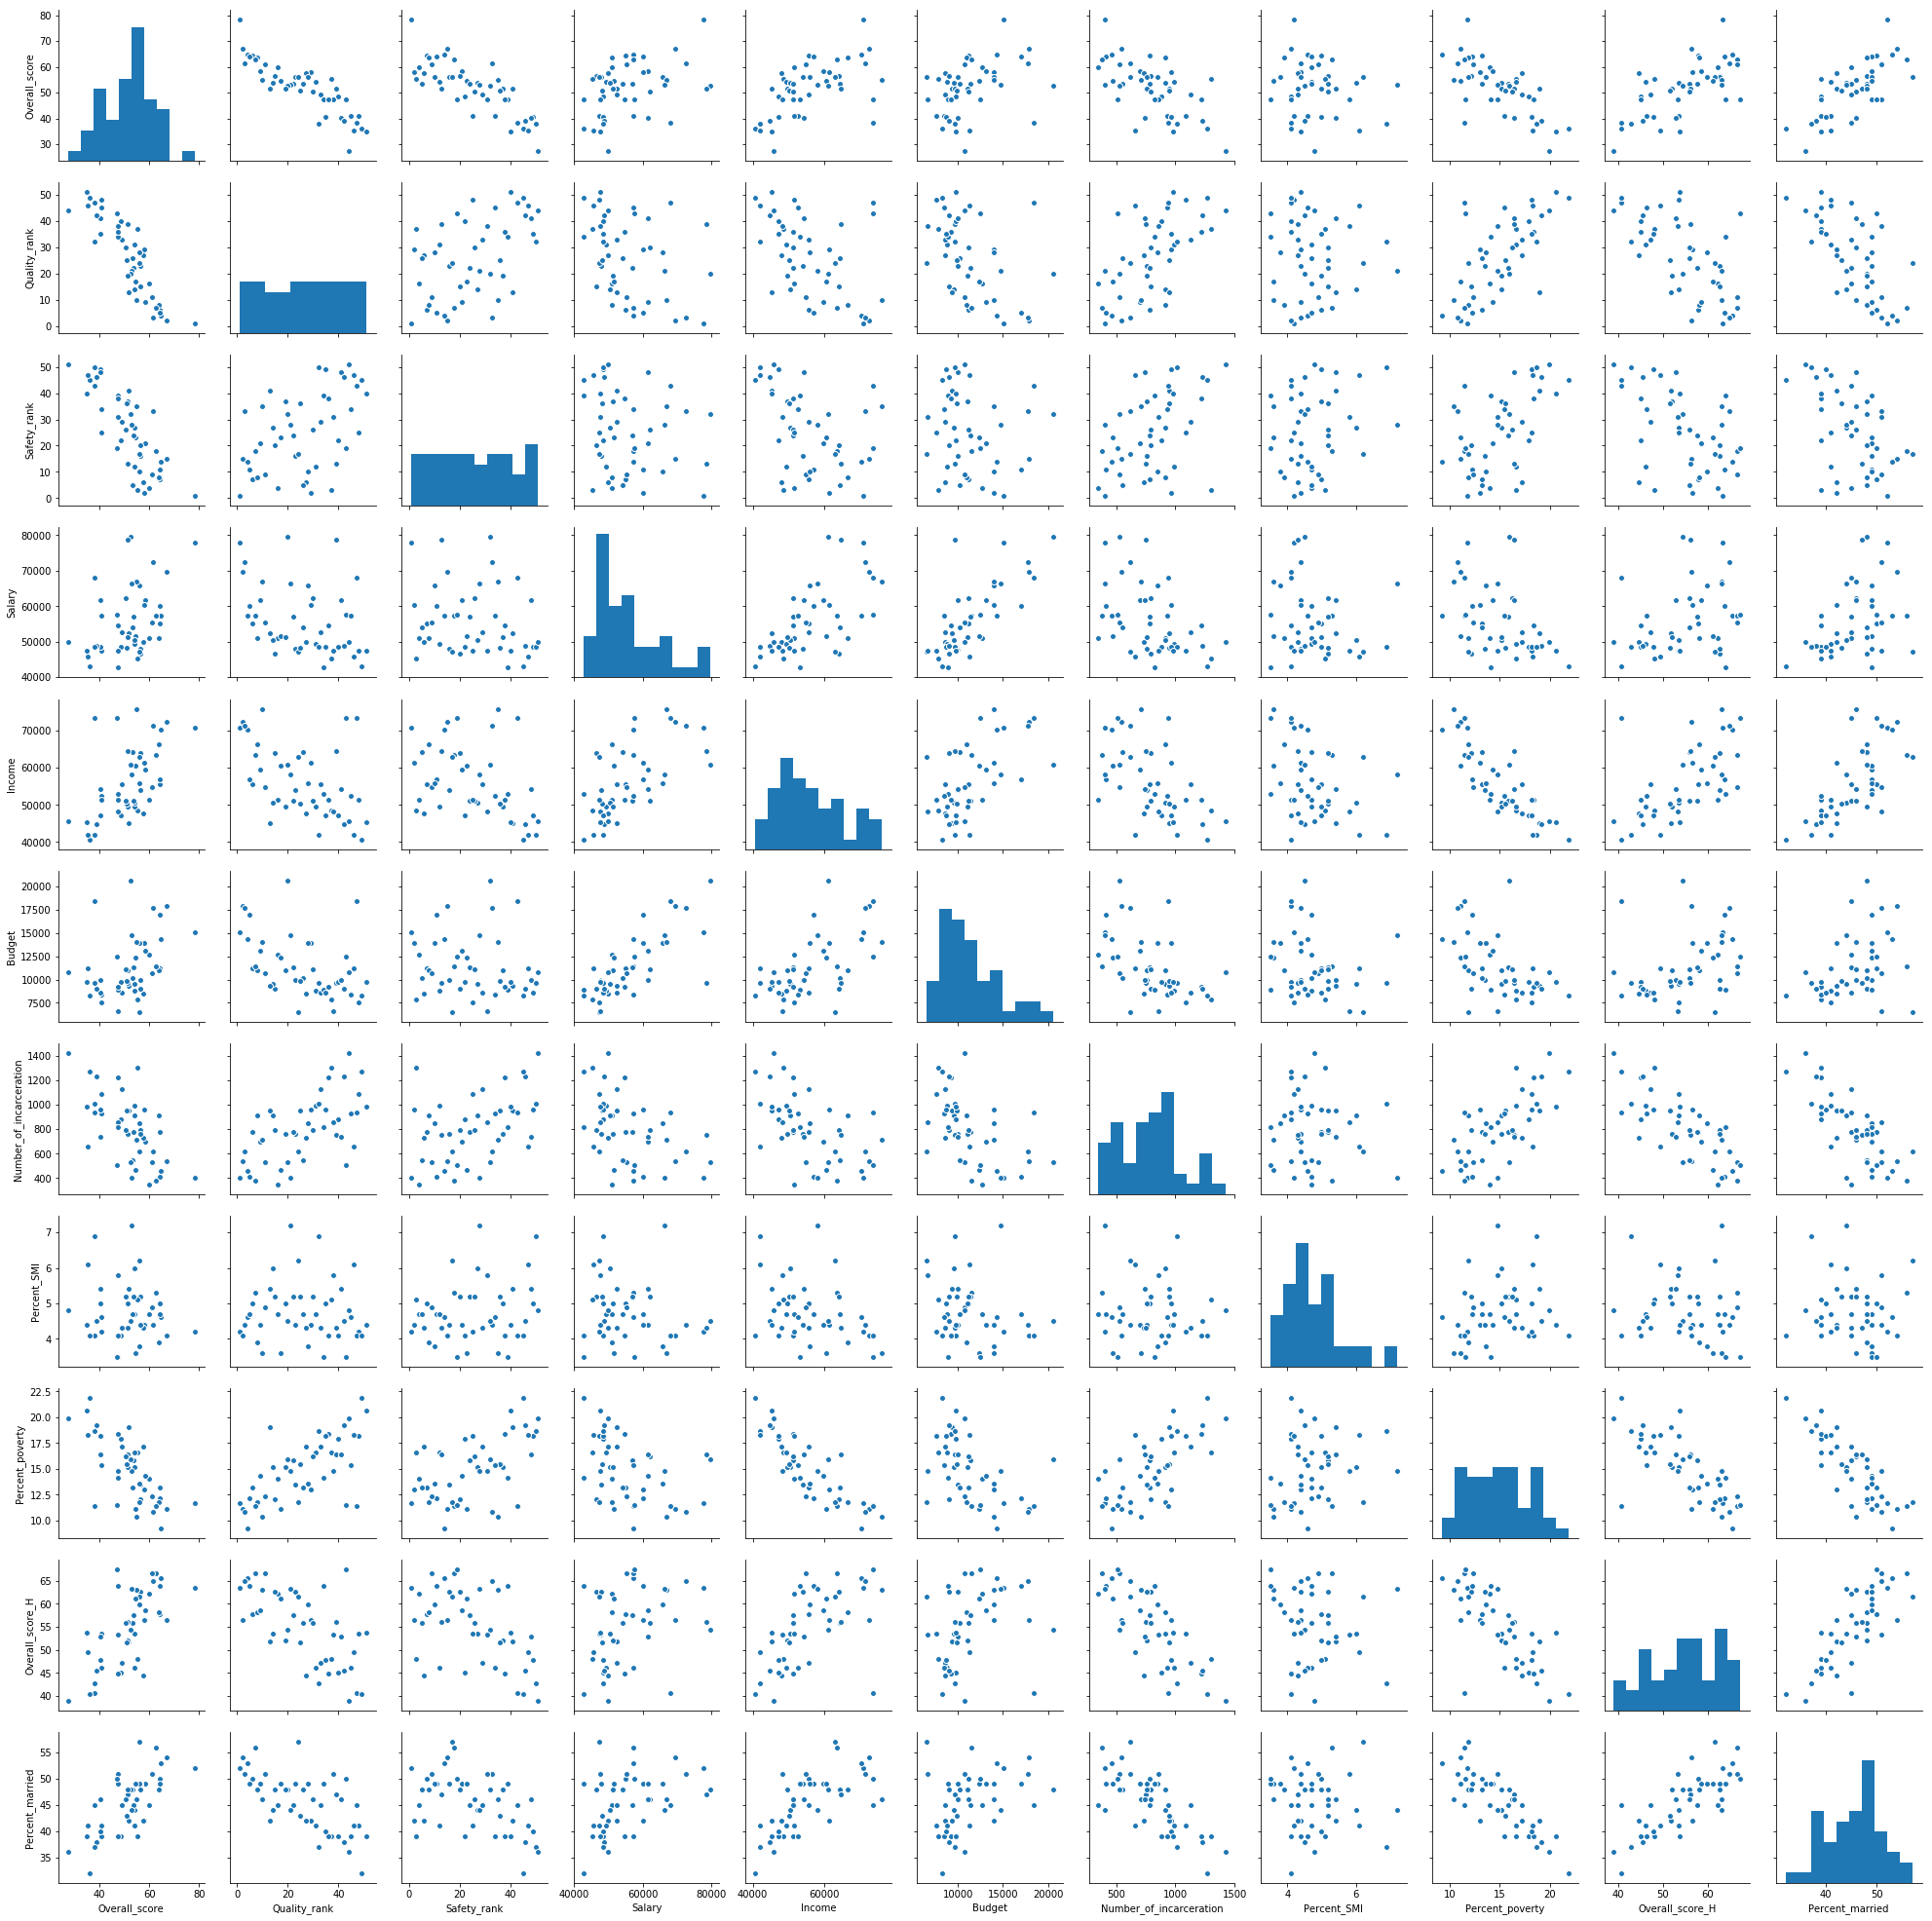

In [58]:
sns.pairplot(result1)

In [59]:
result_mod = result1.copy()

In [60]:
result_mod['log_percent_SMI']=np.log(result_mod.Percent_SMI)
result_mod['log_incarceration']=np.log(result_mod.Number_of_incarceration)
result_mod['log_salary']=np.log(result_mod.Salary)
result_mod['log_budget']=np.log(result_mod.Budget)
result_mod['log_income']=np.log(result_mod.Income)

In [61]:
result_mod.corr()

,Overall_score,Quality_rank,Safety_rank,Salary,Income,Budget,Number_of_incarceration,Percent_SMI,Percent_poverty,Overall_score_H,Percent_married,log_percent_SMI,log_incarceration,log_salary,log_budget,log_income
Overall_score,1.000000,-0.870543,-0.798956,0.397292,0.559595,0.379418,-0.627074,-0.131972,-0.718104,0.672950,0.704728,-0.120643,-0.619010,0.408091,0.390309,0.586579
Quality_rank,-0.870543,1.000000,0.488974,-0.361223,-0.498897,-0.465702,0.616553,-0.027035,0.676407,-0.642890,-0.662595,-0.034926,0.610636,-0.379961,-0.487839,-0.515545
Safety_rank,-0.798956,0.488974,1.000000,-0.202369,-0.405059,-0.138569,0.442733,0.209957,0.539715,-0.504480,-0.484275,0.192594,0.447747,-0.214440,-0.153783,-0.440118
Salary,0.397292,-0.361223,-0.202369,1.000000,0.648897,0.758127,-0.454299,-0.177429,-0.412568,0.310051,0.397297,-0.181829,-0.441029,0.996260,0.741649,0.650667
Income,0.559595,-0.498897,-0.405059,0.648897,1.000000,0.602636,-0.551058,-0.365149,-0.851151,0.594387,0.691589,-0.385579,-0.528633,0.657461,0.590733,0.996464
Budget,0.379418,-0.465702,-0.138569,0.758127,0.602636,1.000000,-0.517864,-0.214484,-0.510921,0.336213,0.364298,-0.225807,-0.531544,0.761666,0.987415,0.592591
Number_of_incarceration,-0.627074,0.616553,0.442733,-0.454299,-0.551058,-0.517864,1.000000,-0.058711,0.692920,-0.771355,-0.746797,-0.040202,0.980900,-0.465845,-0.532297,-0.566055
Percent_SMI,-0.131972,-0.027035,0.209957,-0.177429,-0.365149,-0.214484,-0.058711,1.000000,0.199595,-0.084646,-0.062378,0.993603,-0.061865,-0.170402,-0.225947,-0.359468
Percent_poverty,-0.718104,0.676407,0.539715,-0.412568,-0.851151,-0.510921,0.692920,0.199595,1.000000,-0.751678,-0.834091,0.215854,0.661258,-0.434811,-0.513524,-0.864656
Overall_score_H,0.672950,-0.642890,-0.504480,0.310051,0.594387,0.336213,-0.771355,-0.084646,-0.751678,1.000000,0.792286,-0.105507,-0.751174,0.321140,0.365304,0.619221


In [62]:
result_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 47
Data columns (total 17 columns):
State                      48 non-null object
Overall_score              48 non-null float64
Quality_rank               48 non-null int64
Safety_rank                48 non-null int64
Salary                     48 non-null int64
Income                     48 non-null int64
Budget                     48 non-null int64
Number_of_incarceration    48 non-null int64
Percent_SMI                48 non-null float64
Percent_poverty            48 non-null float64
Overall_score_H            48 non-null float64
Percent_married            48 non-null int64
log_percent_SMI            48 non-null float64
log_incarceration          48 non-null float64
log_salary                 48 non-null float64
log_budget                 48 non-null float64
log_income                 48 non-null float64
dtypes: float64(9), int64(7), object(1)
memory usage: 6.8+ KB


In [63]:
pd.to_pickle(result_mod,'result_mod.pkl')

In [65]:
result.head(5)

,State,Overall_score,Quality_rank,Safety_rank,Starting_salary,Salary,Income,General_Administration,Instruction_Employee_Benefits,Instruction_Employee_Salaries,...,Days_of_instruction,Number_of_incarceration,Percent_SMI,Percent_AMI,Percent_poverty,Overall_score_H,Cost_h_rank,Access_h_rank,Outcome_h_rank,Percent_married
0,Massachusetts,78.16,1,1,44726,77804,70628,204,2447,6343,...,180,400,4.2,20.2,11.7,63.36,41,3,2,52
1,NewJersey,66.92,2,15,51179,69623,72222,367,2782,6888,...,180,540,4.1,18.3,11.1,56.43,29,39,12,54
2,NewHampshire,64.65,4,14,36845,57253,70303,495,2563,5673,...,180,460,4.6,19.6,9.2,65.54,16,4,7,53
3,Wisconsin,64.25,6,7,36983,54998,55638,305,1877,4310,...,180,780,5.0,21.2,13.2,57.80,25,16,22,50
4,Vermont,64.09,5,11,38483,60187,56990,386,2756,6564,...,175,410,4.7,19.7,12.2,63.87,20,18,3,49


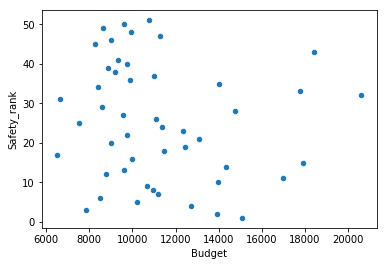

In [69]:
result.plot.scatter('Budget', 'Safety_rank')